In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import arviz as az

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Preparation of results for business: Newpaper Sales

We will illustrate how to prepare results for a business audience using ArviZ. The motivating example we'll use is a classic example in Industrial Engineering, the [newsvendor problem](https://en.wikipedia.org/wiki/Newsvendor_model). In brief the problem is as follows

As a newpaper girl, or boy, you face a dilemma; buy too many newspapers and you'll lose money from newspaper that expire. Buy too few newspapers and you'll miss potential sales, and lose money. Using past sales information and ArviZ we can create a compelling data centric pitch about what business choice to make in this scenario


## Outline

* Posterior Estimation
* Posterior Predictive

### Simulation

As we have in past chapters we're going to create some simulated sales data. Our latent (hidden) parameter is 30 sales per a day on average, and we are simulated 20 days of sales. We are using the poisson distribution because we can only sell positive whole numbers of newspapers (e.g. 12, 14,21)

In [2]:
newspaper_sales = stats.poisson.rvs(30, size=20)

### The observed data
At the end of 20 days these are the sales numbers we see. Given 20 days of sales you must make a case of how many newspapers to buy in the future.

In [3]:
newspaper_sales

array([29, 28, 24, 30, 32, 37, 24, 31, 27, 24, 33, 23, 22, 32, 29, 28, 27,
       34, 31, 31])

## Fitting the data
Before any results can be prepared we must first fit a model and generate some results

In [4]:
with pm.Model() as newspaper_model:
    _lambda = pm.Normal("λ", newspaper_sales.mean(), 10)
    
    sales = pm.Poisson("sales", _lambda, observed=newspaper_sales)
    trace = pm.sample(draws=2000)
    ppc = pm.sample_posterior_predictive(trace)
    
data = az.from_pymc3(trace=trace, posterior_predictive=ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [λ]
100%|██████████| 4000/4000 [00:02<00:00, 1820.51it/s]


## Preparation of results
Using ArviZ there are numerous ways we can share the results depending on audience. The three will we cover are a numerical Summary with `az.summary`, posterior parameter estimation using `az.plot_posterior`, and posterior predictive visualization using `az.ppc_plot`

### Numerical Summary of estimated parameters using az.summary
The simplest way to share the result is using the numerical summuraization in az.summary

In [5]:
az.summary(data)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
λ,28.829,1.183,26.631,31.001,0.029,0.021,1644.0,1644.0,1651.0,2751.0,1.0


Using the above summary we get a couple of useful data points. The mean of the expected number of sales each day is ~30.2 and the standard deviation of sales is ~1.2. The advantages of a numerical summary is the ease of communication and succintness. Often times in business settings you may need to describe results without the aid of computer, or chart. Additionally in most businesses your surrounding colleagues will likely not be statisticians. However most people can intuit around the idea of mean and standard deviation, and providing a mean and sd estimate is quick and is not overwhelming.

There are some downsides to numerical summaries. One is that by summarizing to two numbers, a lot of information is "left on the table". Additionally in certain contexts when a visualization can be used, it's often much more memorable to show a picture of the parameter estimation than provide two summary statistics. Lastly the mean, standard deviation, and even the hpd estimates, don't characterize all distributions well. For exmaple in our newspaper problem if the distribution was bimodal, perhaps because of weekday sales and weekend sales, none of the numerical estimates would correctly communicate this condition.

### Visual Summary of estimated paramters using plot_posterior

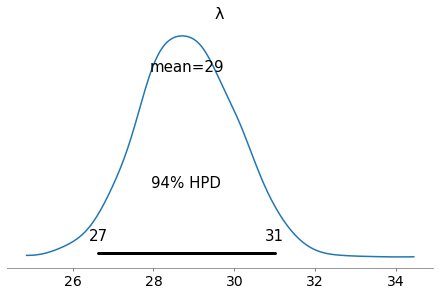

In [6]:
az.plot_posterior(data);

With plot posterior we get a nice visualization of the parameter estimates, as well as point estimate and the Highest Posterior Density. In contrast to the numerical estimates a posterior plot is much harder to gloss over. Posterior Plots also characterize all, or nearly all, the information inferred about the estimated parameters, including uncertainty and characteristics of the distribution.

As with any visualization though this cannot be used outside of a visual presentation format. It can be awkward to describe to non statisticians verbally. Additionally posterior by nature are the estimated distribution of *parameter space*. Many times people that are unfamiliar with Bayesian Statistics will incorrectly assume that the x axis is in the units of data, in this case newspaper sales. This intrepratation can lead to incorrect results, as colleagues may assume that "there is a 94% chance that 28 to 31 newspapers will be sold in a day" and are in for a surprise when on many occassions more or less papers are sold.

### Visual Summary of estimated sales using Posterior Predictive Plot

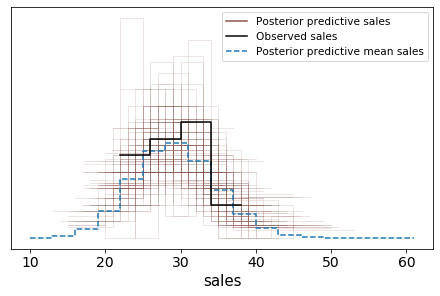

In [7]:
az.plot_ppc(data, num_pp_samples=100);

With plot_ppc we get a plot of the observed data along with the simulated outcomes from the parameter estimations. Benefits if the Posterior Predictive plot are the same as the posterior plot, but with the notable change that the x axis is in the units of the data. Posterior Predictive Plots then lend themselves to the correct interpretation that "15 to 40 newspapers will be sold a day, and lesser likely that 10 or 45 will be sold"

The downside to the posterior plot is that if asked to explained how they are generated it's not typically a straightforward exercise. From personal experience if trying to explain that you fit parameters using Bayesian Statistics to estimate the posterior, then generated "1000", or any arbitrary number, of future simulations, then took the KDE of them, most colleagues lose interest quickly.

## Practical Advice for using ArviZ in business settings
As a statistician in the workplace your job is to help others make good decisions using data. This naturally requires your analysis to be rigorous and thorough, but also requires you to present it in a way that others will take heed to the results. If your boss  becomes bored with the details of Posterior Plots and subsequently fails to understand the conclusion. then your analysis was as ineffective as not running an analysis at all. 

My advice would be to know your audience. their tolerance for mathematical explanations, and understand the context in which you can explain the data. If you're providing a visual presentation, and have a couple minutes, consider using the Posterior Plot or Posterior Predictive Plot as it lends itself to a longer explanation. If you're given less time consider using the numerical summaries from `az.summary` to quickly convey your results.

In either scenario I would suggest memorizing a couple of the numerical summaries, such as mean, median, or HPD, so if an opportunity arises in a "hallway" conversation, or during a meeting without a presentation you are able to share results quickly and without a visual aid.